### Importing necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Getting New York JSON file

In [2]:
with open(r'C:\Users\MONSTER\Desktop\ny.json') as json_data:
    newyork_data = json.load(json_data)

### Exploring JSON file

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

### Creating a suitable dataframe

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Using folium library to create a map

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Narrowing down to Manhattan

In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [14]:
CLIENT_ID = '05Y4VHYPLZQYH2NXVX5CDSII0FNABH54BRFIFL02GNRCXP0N' # your Foursquare ID
CLIENT_SECRET = 'RJMXBRLBG2K0VKK0RZEBDQYYKSYUEY4LJUCLSLBRUIZQL3Y3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 05Y4VHYPLZQYH2NXVX5CDSII0FNABH54BRFIFL02GNRCXP0N
CLIENT_SECRET:RJMXBRLBG2K0VKK0RZEBDQYYKSYUEY4LJUCLSLBRUIZQL3Y3


In [15]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [16]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


### Discovering 100 venues with radius 500 meters

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
LIMIT = 100
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [19]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3161, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [20]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Carnegie Hill,88,88,88,88,88,88
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


Here, found out that some of the neighborhoods do not have 100 venues in 500 meters

In [21]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 323 uniques categories.


In [22]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaur

In [23]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()


## Preparing data frame that only has related columns

In [24]:
m = manhattan_onehot.groupby('Neighborhood').sum().reset_index()

In [25]:
gym = m[['Neighborhood','Gym','Gym / Fitness Center','Boxing Gym','Climbing Gym','Cycle Studio','Gym Pool','Gymnastics Gym','Supplement Shop']]

In [26]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop
0,Battery Park City,4,0,0,0,0,0,0,0
1,Carnegie Hill,3,3,0,0,0,0,0,0
2,Central Harlem,1,2,0,0,1,0,0,0
3,Chelsea,1,2,0,0,2,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0
6,Clinton,3,5,0,0,0,0,0,0
7,East Harlem,1,0,0,0,0,0,0,0
8,East Village,0,0,0,0,0,0,0,0
9,Financial District,3,3,0,0,1,0,0,0


In [27]:
gym['Total'] = gym.sum(axis=1)

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Finding the most common venues for each neighborhood

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Boat or Ferry,Italian Restaurant,Pizza Place,Playground,Plaza
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Bakery,Bookstore,Cosmetics Shop,Gym,Gym / Fitness Center,Japanese Restaurant
2,Central Harlem,Gym / Fitness Center,American Restaurant,Seafood Restaurant,Chinese Restaurant,Bar,African Restaurant,Fried Chicken Joint,French Restaurant,Event Space,Library
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Bakery,Cocktail Bar,Pizza Place,Pet Store,Nightclub,Market
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Dessert Shop,Spa,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Salon / Barbershop


## Clustering Neighborhoods

In [30]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 0, 2, 2, 3, 0, 1])

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data


manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Gym,Coffee Shop,Kids Store,Steakhouse,Miscellaneous Shop,Supplement Shop,Shopping Mall,Seafood Restaurant,Tennis Stadium
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Dessert Shop,Spa,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Salon / Barbershop
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Bakery,Grocery Store,Chinese Restaurant,Mobile Phone Shop,Deli / Bodega,Coffee Shop,New American Restaurant,Tapas Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Restaurant,Park,Bakery,Frozen Yogurt Shop,Pharmacy,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Deli / Bodega,Cocktail Bar,Liquor Store,Sushi Restaurant,Yoga Studio,Chinese Restaurant


In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
cluster0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [34]:
cluster1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [35]:
cluster2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [36]:
cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [37]:
cluster4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [38]:
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Dessert Shop,Spa,Hotpot Restaurant,Vietnamese Restaurant,Optical Shop,Salon / Barbershop
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Pizza Place,Wine Shop,Sushi Restaurant,Diner,Japanese Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Coffee Shop,Vegetarian / Vegan Restaurant,Pub,Bagel Shop,Sports Bar,Bookstore,Thai Restaurant
19,East Village,Bar,Pizza Place,Coffee Shop,Mexican Restaurant,Wine Bar,Ice Cream Shop,Ramen Restaurant,Speakeasy,Korean Restaurant,Cocktail Bar
20,Lower East Side,Chinese Restaurant,Ramen Restaurant,Art Gallery,Pizza Place,Bakery,Pharmacy,Café,Japanese Restaurant,Park,Coffee Shop
25,Manhattan Valley,Coffee Shop,Mexican Restaurant,Indian Restaurant,Bar,Yoga Studio,Chinese Restaurant,Thai Restaurant,Pizza Place,Caribbean Restaurant,Hawaiian Restaurant
27,Gramercy,Italian Restaurant,American Restaurant,Pizza Place,Bar,Coffee Shop,Cocktail Bar,Playground,Mexican Restaurant,Ice Cream Shop,Grocery Store
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,Clothing Store,American Restaurant,Gym / Fitness Center,Bar,Burger Joint,Gym


## Sorting and eleminating sports kind of data

In [39]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
0,Battery Park City,4,0,0,0,0,0,0,0,4
1,Carnegie Hill,3,3,0,0,0,0,0,0,6
2,Central Harlem,1,2,0,0,1,0,0,0,4
3,Chelsea,1,2,0,0,2,0,0,0,5
4,Chinatown,0,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0,6
6,Clinton,3,5,0,0,0,0,0,0,8
7,East Harlem,1,0,0,0,0,0,0,0,1
8,East Village,0,0,0,0,0,0,0,0,0
9,Financial District,3,3,0,0,1,0,0,0,7


In [40]:
gym_sorted = gym.sort_values(by='Total', ascending = False)

In [41]:
gym_sorted.head()

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
10,Flatiron,3,5,0,0,3,0,0,0,11
17,Lincoln Square,2,5,0,1,2,0,0,0,10
31,Sutton Place,4,5,0,0,1,0,0,0,10
16,Lenox Hill,3,3,0,0,2,0,0,1,9
6,Clinton,3,5,0,0,0,0,0,0,8


### Importing necessary libraries

In [42]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

### Getting only total numbers for each neighborhood

In [43]:
gymsum = gym[['Neighborhood','Total']]
gymsum.head()

,Neighborhood,Total
0,Battery Park City,4
1,Carnegie Hill,6
2,Central Harlem,4
3,Chelsea,5
4,Chinatown,0


### Sorting by total numbers in order to create a effective bar chart

In [44]:
gymsum_sorted = gymsum.sort_values(by='Total', ascending = False)

In [45]:
gymsum_sorted.head()

,Neighborhood,Total
10,Flatiron,11
17,Lincoln Square,10
31,Sutton Place,10
16,Lenox Hill,9
6,Clinton,8


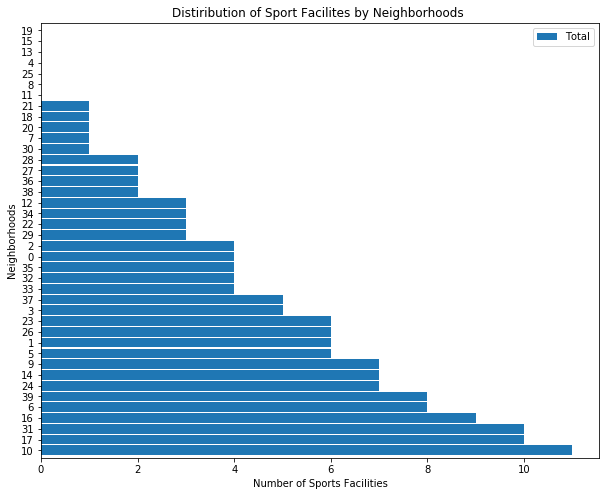

In [46]:

gymsum_sorted.plot(kind='barh', width = 0.9, figsize=(10, 8))

plt.ylabel('Neighborhoods') # add to x-label to the plot
plt.xlabel('Number of Sports Facilities') # add y-label to the plot
plt.title('Distiribution of Sport Facilites by Neighborhoods ') # add title to the plot

plt.show()

### Changing index names to have a clear vision

In [47]:
a = gymsum_sorted.set_index('Neighborhood')

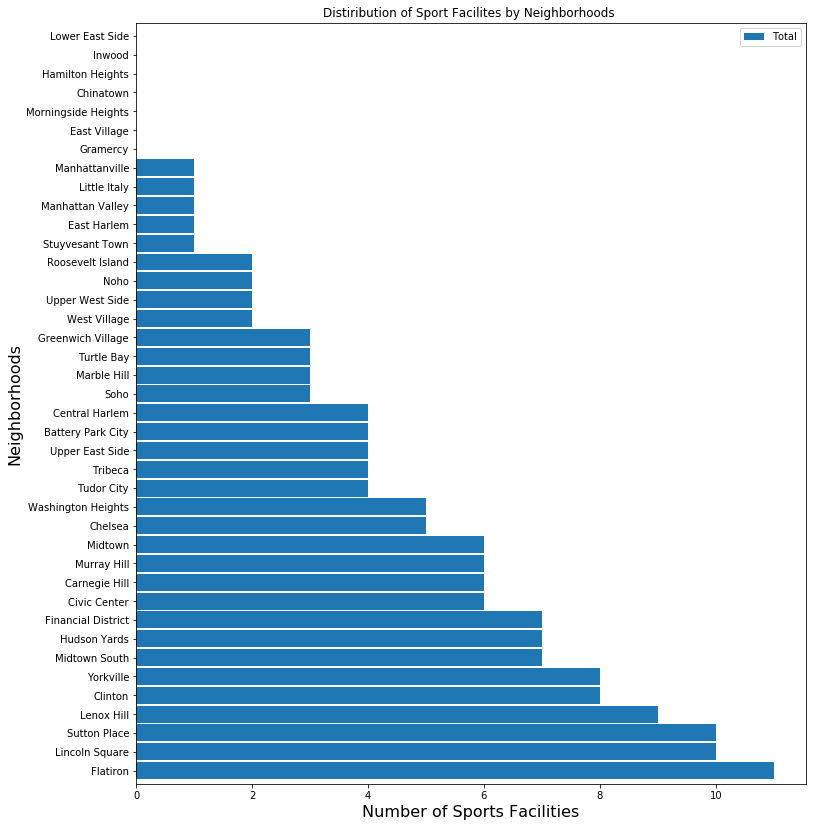

In [48]:
a.plot(kind='barh', width = 0.9, figsize=(12, 14))

plt.ylabel('Neighborhoods', size = 16) # add to x-label to the plot
plt.xlabel('Number of Sports Facilities', size = 16) # add y-label to the plot
plt.title('Distiribution of Sport Facilites by Neighborhoods ') # add title to the plot

plt.show()

Now, we can easily distinguish our top candidates.

In [49]:
a.head()

,Total
Neighborhood,
Flatiron,11
Lincoln Square,10
Sutton Place,10
Lenox Hill,9
Clinton,8


# Analyzing top 5 neighborhoods one by one

In [50]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Sutton Place']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Manhattan,Sutton Place,40.76028,-73.963556,2,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Gym,Furniture / Home Store,Pizza Place,Park,Chinese Restaurant,Beer Garden,Beer Bar


In [51]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Flatiron']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Manhattan,Flatiron,40.739673,-73.990947,2,Gym / Fitness Center,New American Restaurant,Café,Yoga Studio,American Restaurant,Bookstore,Coffee Shop,Cosmetics Shop,Cycle Studio,Furniture / Home Store


In [52]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Lenox Hill']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Manhattan,Lenox Hill,40.768113,-73.95886,2,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Cocktail Bar,Gym,Burger Joint,Café,Gym / Fitness Center,Cycle Studio


In [53]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Yorkville']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Manhattan,Yorkville,40.77593,-73.947118,0,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Pizza Place,Wine Shop,Sushi Restaurant,Diner,Japanese Restaurant


In [54]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Clinton']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Manhattan,Clinton,40.759101,-73.996119,2,Theater,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Spa,Wine Shop,Gym,Hotel,American Restaurant,Thai Restaurant


In [55]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
0,Battery Park City,4,0,0,0,0,0,0,0,4
1,Carnegie Hill,3,3,0,0,0,0,0,0,6
2,Central Harlem,1,2,0,0,1,0,0,0,4
3,Chelsea,1,2,0,0,2,0,0,0,5
4,Chinatown,0,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0,6
6,Clinton,3,5,0,0,0,0,0,0,8
7,East Harlem,1,0,0,0,0,0,0,0,1
8,East Village,0,0,0,0,0,0,0,0,0
9,Financial District,3,3,0,0,1,0,0,0,7


## Distinguishing neighborhoods that already has a supplement shop

In [56]:
gym.loc[gym['Supplement Shop'] > 0]

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
16,Lenox Hill,3,3,0,0,2,0,0,1,9
22,Marble Hill,2,0,0,0,0,0,0,1,3
37,Washington Heights,2,1,0,0,0,0,0,2,5


In [57]:
b = gym[['Neighborhood', 'Supplement Shop']]

In [58]:
c = b.loc[b['Supplement Shop'] > 0]

In [59]:
c

,Neighborhood,Supplement Shop
16,Lenox Hill,1
22,Marble Hill,1
37,Washington Heights,2


### Preparing rental data

In [60]:
rent = pd.read_excel(r'C:\Users\MONSTER\Desktop\rent.xlsx')

In [61]:
rent

,Neighborhood,Average Rent
0,Marble Hill,"$1,708"
1,Washington Heights,"$2,190"
2,Inwood,"$2,375"
3,Randalls and Wards Islands,"$2,408"
4,Harlem,"$2,763"
5,East Harlem,"$3,003"
6,Roosevelt Island,"$3,426"
7,Stuyvesant Town,"$3,628"
8,Liberty Island,"$3,725"
9,Governors Island,"$3,725"


In [62]:
top_5 = ['Sutton Place', 'Flatiron District', 'Lenox Hill', 'Yorkville', "Clinton - Hell's Kitchen"]

In [63]:
top_rent = rent.loc[rent['Neighborhood'].isin(top_5)]

In [64]:
top_rent.replace({"Clinton - Hell's Kitchen":'Clinton', 'Flatiron District':'Flatiron'}, inplace=True)

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [65]:
top_rent

,Neighborhood,Average Rent
16,Clinton,"$4,093"
17,Sutton Place,"$4,138"
21,Lenox Hill,"$4,223"
23,Flatiron,"$4,290"
33,Yorkville,"$4,432"


In [90]:
top_rent['Average Rent'] = top_rent['Average Rent'].str.replace('$','')

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Creating a visual for rental data to compare

In [91]:
top_rent['Average Rent']

16    4,093
17    4,138
21    4,223
23    4,290
33    4,432
Name: Average Rent, dtype: object

In [97]:
top_rent['Average Rent'] = top_rent['Average Rent'].str.replace(',','')

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
top_rent['Average Rent']

16    4093
17    4138
21    4223
23    4290
33    4432
Name: Average Rent, dtype: object

In [99]:
top_rent['Average Rent'].astype(int)

16    4093
17    4138
21    4223
23    4290
33    4432
Name: Average Rent, dtype: int32

In [117]:
top_rent['Average Rent'] = top_rent['Average Rent'].astype(float)

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
top_rent

,Neighborhood,Average Rent
16,Clinton,4093.0
17,Sutton Place,4138.0
21,Lenox Hill,4223.0
23,Flatiron,4290.0
33,Yorkville,4432.0


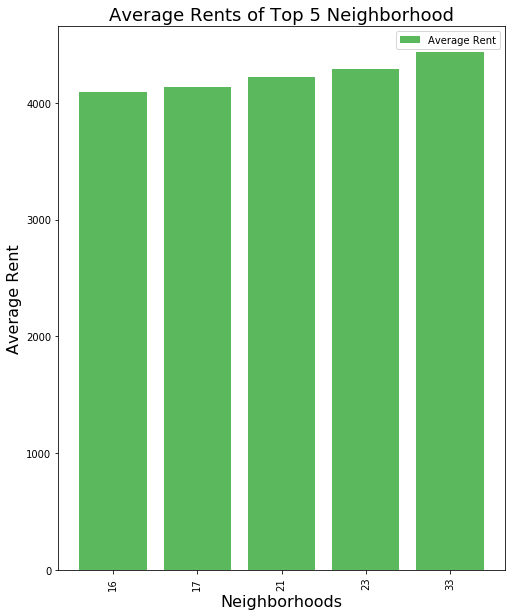

In [128]:
top_rent.plot(kind='bar', width = 0.8, figsize=(8, 10), color = '#5cb85c')

plt.ylabel('Average Rent', size = 16) # add to x-label to the plot
plt.xlabel('Neighborhoods', size = 16) # add y-label to the plot
plt.title('Average Rents of Top 5 Neighborhood', size=18) # add title to the plot

plt.show()

In [129]:
b = top_rent.set_index('Neighborhood')
b

,Average Rent
Neighborhood,
Clinton,4093.0
Sutton Place,4138.0
Lenox Hill,4223.0
Flatiron,4290.0
Yorkville,4432.0


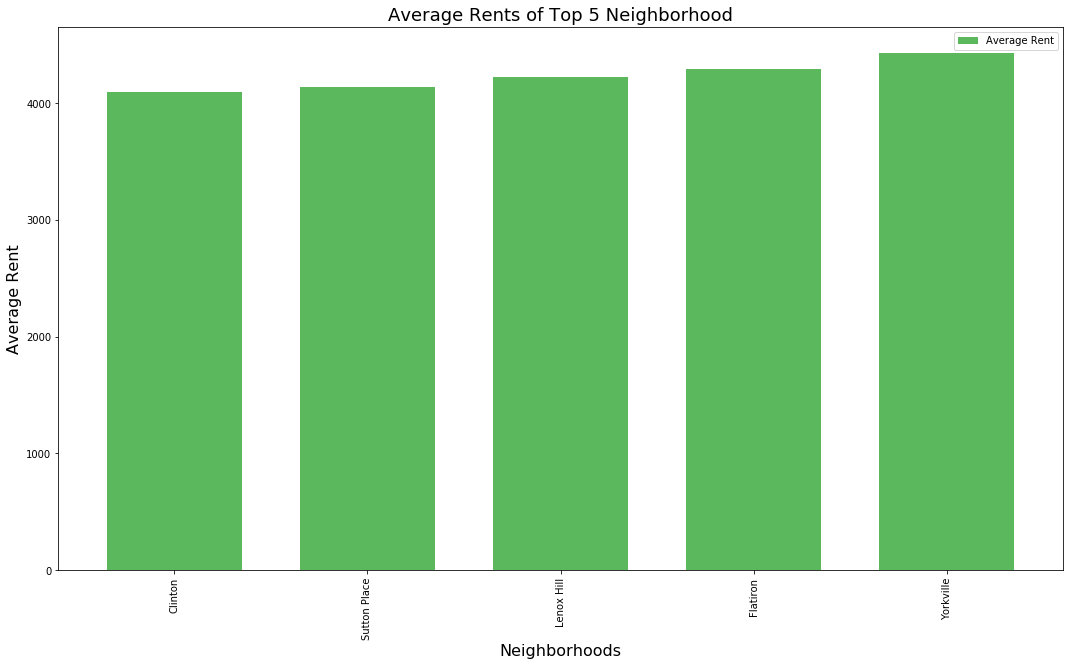

In [142]:
b.plot(kind='bar', width = 0.7, figsize=(18, 10), color = '#5cb85c')

plt.ylabel('Average Rent', size = 16) # add to x-label to the plot
plt.xlabel('Neighborhoods', size = 16) # add y-label to the plot
plt.title('Average Rents of Top 5 Neighborhood', size=18) # add title to the plot

plt.show()

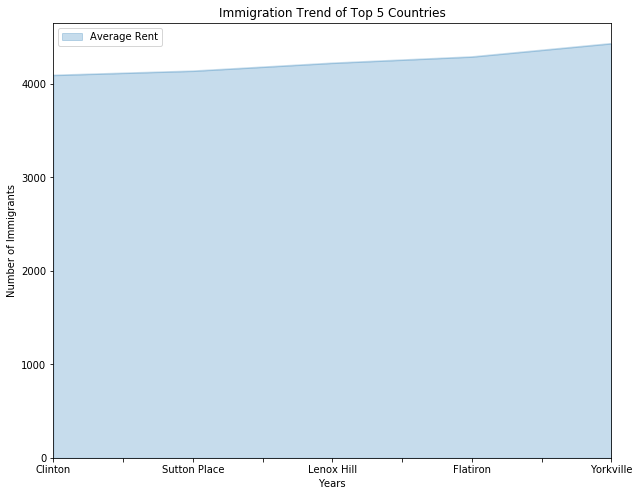

In [132]:
b.plot(kind='area', 
             alpha=0.25, # 0-1, default value a= 0.5
             stacked=False,
             figsize=(10, 8),
            )

plt.title('Immigration Trend of Top 5 Countries')
plt.ylabel('Number of Immigrants')
plt.xlabel('Years')

plt.show()

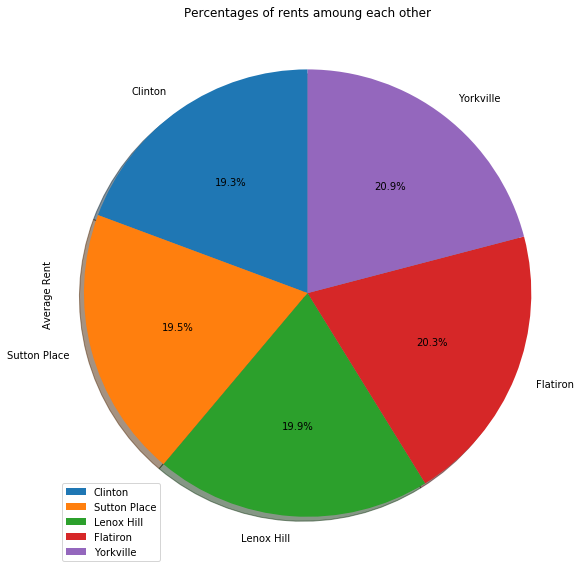

In [138]:
b.plot(kind='pie',
                            figsize=(9, 10),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,
                            subplots=True # add shadow      
                            )

plt.title('Percentages of rents amoung each other')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()